In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ahmedakram1","key":"66701960f6726013c71587d887b8253a"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c digit-recognizer

  0% 0.00/15.3M [00:00<?, ?B/s]
100% 15.3M/15.3M [00:00<00:00, 1.44GB/s]


In [4]:
!unzip /content/digit-recognizer.zip

Archive:  /content/digit-recognizer.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

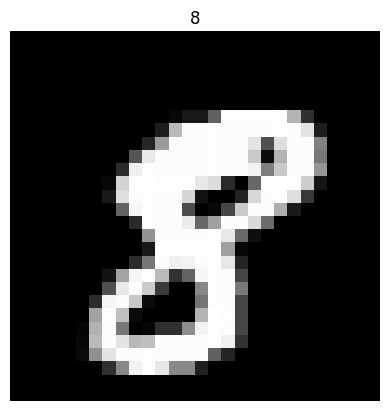

In [6]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

train = pd.read_csv("/content/train.csv")

targets_numpy = train.label.values
features_numpy = train.drop('label', axis=1).values / 255.0

# Train / Validation split
features_train, features_val, targets_train, targets_val = train_test_split(
    features_numpy, targets_numpy, test_size=0.2, random_state=42
)

featuresTrain = torch.from_numpy(features_train).float()
targetsTrain = torch.from_numpy(targets_train).long()

featuresVal = torch.from_numpy(features_val).float()
targetsVal = torch.from_numpy(targets_val).long()

BATCH_SIZE = 100
train_dataset = TensorDataset(featuresTrain, targetsTrain)
val_dataset   = TensorDataset(featuresVal, targetsVal)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_data = pd.read_csv("/content/test.csv").values / 255.0
featuresTest = torch.from_numpy(test_data).float()

test_dataset = TensorDataset(featuresTest)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

plt.imshow(features_numpy[10].reshape(28, 28), cmap="gray")
plt.axis("off")
plt.title(str(targets_numpy[10]))
plt.show()

In [15]:
class RNNModel(nn.Module):
  def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
    super(RNNModel, self).__init__()

    self.hidden_dim = hidden_dim
    self.layer_dim = layer_dim

    self.rnn = nn.RNN(input_size = input_dim,
                      hidden_size= hidden_dim,
                      num_layers = layer_dim,
                      batch_first = True,
                      nonlinearity="relu")

    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):

    out, _ = self.rnn(x)
    out = self.fc(out[:, -1, :])
    return out

In [16]:
BATCH_SIZE = 100
n_iters = 8000
num_epochs = n_iters / (len(features_train) / BATCH_SIZE)
num_epochs = int(num_epochs)

print(num_epochs)

23


In [33]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [53]:
input_dim = 28
hidden_dim = 100
layer_dim = 1
output_dim = 10

model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)
model.to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 25, gamma=0.1)

In [54]:
seq_dim = 28
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

num_epochs = 26

for epoch in range(num_epochs):
  model.train()
  running_loss, running_correct, total = 0.0, 0, 0

  for i, (image, label) in enumerate(train_loader):
    image, label = image.view(-1, seq_dim, input_dim).to(device).float(), label.to(device)

    optimizer.zero_grad()
    outputs = model(image)
    loss = criterion(outputs, label)
    loss.backward()
    optimizer.step()

    running_loss += loss.item() * label.size(0)
    _, predicted = torch.max(outputs, 1)
    running_correct += (predicted == label).sum().item()
    total += label.size(0)

  train_loss = running_loss / total
  train_acc = running_correct / total
  train_losses.append(train_loss)
  train_accuracies.append(train_acc)

  model.eval()
  val_running_loss, val_running_correct, val_total = 0.0, 0, 0

  with torch.no_grad():
    for image, label in val_loader:
        image = image.view(-1, seq_dim, input_dim).to(device).to(torch.float32)
        label = label.to(device)
        outputs = model(image)
        loss = criterion(outputs, label)

        val_running_loss += loss.item() * label.size(0)
        _, predicted = torch.max(outputs, 1)
        val_running_correct += (predicted == label).sum().item()
        val_total += label.size(0)

  val_loss = val_running_loss / val_total
  val_acc = val_running_correct / val_total
  val_losses.append(val_loss)
  val_accuracies.append(val_acc)

  scheduler.step()

  print(f"Epoch [{epoch+1}/{num_epochs}] "
      f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}% "
      f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")

Epoch [1/26] Train Loss: 1.2248, Train Acc: 56.53% Val Loss: 0.7537, Val Acc: 75.76%
Epoch [2/26] Train Loss: 0.6150, Train Acc: 80.24% Val Loss: 0.5088, Val Acc: 84.15%
Epoch [3/26] Train Loss: 0.4420, Train Acc: 86.41% Val Loss: 0.3746, Val Acc: 88.61%
Epoch [4/26] Train Loss: 0.3459, Train Acc: 89.40% Val Loss: 0.3226, Val Acc: 90.29%
Epoch [5/26] Train Loss: 0.2971, Train Acc: 91.15% Val Loss: 0.2722, Val Acc: 91.85%
Epoch [6/26] Train Loss: 0.2536, Train Acc: 92.20% Val Loss: 0.2392, Val Acc: 92.62%
Epoch [7/26] Train Loss: 0.2345, Train Acc: 92.96% Val Loss: 0.2378, Val Acc: 93.01%
Epoch [8/26] Train Loss: 0.2002, Train Acc: 93.97% Val Loss: 0.2121, Val Acc: 93.44%
Epoch [9/26] Train Loss: 0.1822, Train Acc: 94.42% Val Loss: 0.2292, Val Acc: 92.88%
Epoch [10/26] Train Loss: 0.1793, Train Acc: 94.52% Val Loss: 0.1886, Val Acc: 94.17%
Epoch [11/26] Train Loss: 0.1571, Train Acc: 95.30% Val Loss: 0.1544, Val Acc: 95.17%
Epoch [12/26] Train Loss: 0.1547, Train Acc: 95.29% Val Loss: 0

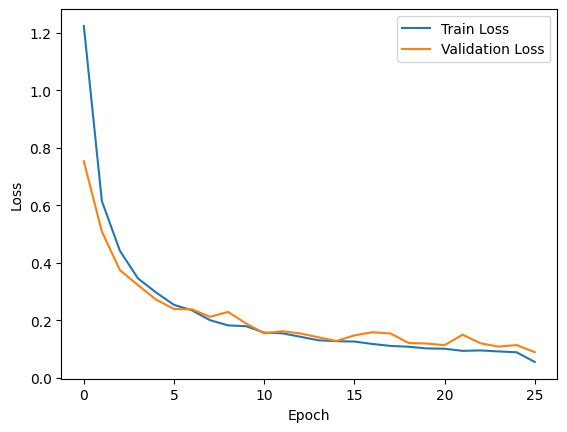

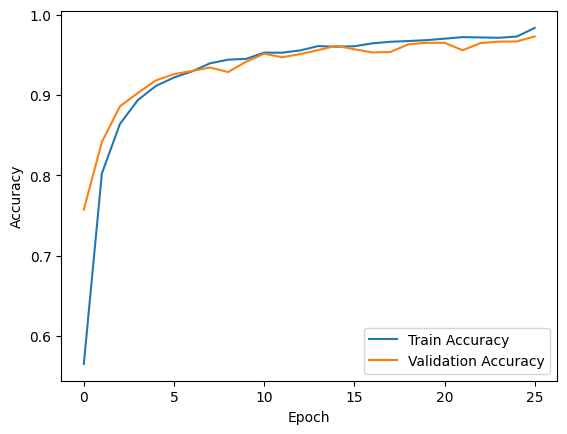

In [55]:
# Loss curve
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy curve
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Thank You